### Файл train.ipynb
Тетрадка с кодом обучения модели,
которая при запуске Run без дополнительных
модификаций, позволяет получить ту же самую
модель, которая используется для прогноза в
следующем ноутбуке (main.ipynb).

### Клон репозитория

In [ ]:
!git clone https://github.com/samoletpanfilov/reinforcement_task.git

fatal: destination path 'reinforcement_task' already exists and is not an empty directory.


### Установка зависимостей

In [ ]:
!pip install tsfresh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import settings

import xgboost as xgb

import pickle

%matplotlib inline
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### Загрузка данных

In [ ]:
test = pd.read_excel("/content/reinforcement_task/data/test.xlsx")
train = pd.read_excel("/content/reinforcement_task/data/train.xlsx")
sample_submission = pd.read_excel("/content/reinforcement_task/sample_submission.xlsx")

# Подготовка данных

In [ ]:
# Подготовка тренировочной выборки
df_train = pd.DataFrame()
df_train['Date'] = pd.to_datetime(train['dt'])
df_train['Price'] = train['Цена на арматуру']
df_train['istest'] = 0

# Подготовка тестовой выборки
df_test = pd.DataFrame()
df_test['Date'] = pd.to_datetime(test['dt'])
df_test['Price'] = test['Цена на арматуру']
df_test['istest'] = 1

# Конкатинируем в один датасет с метрой `istest`
raw = pd.concat((df_train, df_test)).reset_index(drop=True)

# Выделяем временные признаки
raw["day_sin"] = np.sin(raw["Date"].dt.day)
raw["day_cos"] = np.cos(raw["Date"].dt.day)

# Посмотрим на тип переменных
raw.dtypes

Date       datetime64[ns]
Price               int64
istest              int64
day_sin           float64
day_cos           float64
dtype: object

In [ ]:
raw.head(7)

,Date,Price,istest,day_sin,day_cos
0,2015-01-05,32900,0,-0.958924,0.283662
1,2015-01-12,32500,0,-0.536573,0.843854
2,2015-01-19,32000,0,0.149877,0.988705
3,2015-01-26,30700,0,0.762558,0.646919
4,2015-02-02,30300,0,0.909297,-0.416147
5,2015-02-09,30300,0,0.412118,-0.911130
6,2015-02-16,30100,0,-0.287903,-0.957659


In [ ]:
# Создадим матрицы со сдвигом, то есть сделаем так, чтобы значение
# цены на следующую неделю являлось "неизвестным для модели"
X = raw.drop(columns=['Price']).iloc[:-1, :]
y = raw['Price'].values[1:]

X['Price_target'] = y
X['Price_source'] = raw['Price'].values[:-1]

# Подсчитаем разницу между текущим и прошлым значением цены на покупку арматуры
price_diff = X['Price_source'] - X['Price_target']

# Удаляем первую строку
X = X.drop([0])

# Добавляем разницу в цене
X['Price_Diff'] = price_diff.values[:-1]

In [ ]:
# Посмотрим на конец тренировочной выборки
X[X['istest'] == 0].tail()

,Date,istest,day_sin,day_cos,Price_target,Price_source,Price_Diff
395,2022-08-01,0,0.841471,0.540302,49000,47500,0
396,2022-08-08,0,0.989358,-0.145500,47500,49000,-1500
397,2022-08-15,0,0.650288,-0.759688,46500,47500,1500
398,2022-08-22,0,-0.008851,-0.999961,46000,46500,1000
399,2022-08-29,0,-0.663634,-0.748058,46000,46000,500


In [ ]:
# Посмотрим на начало тестовой выборки
X[X['istest'] == 1].head()

,Date,istest,day_sin,day_cos,Price_target,Price_source,Price_Diff
400,2022-09-05,1,-0.958924,0.283662,46000,46000,0
401,2022-09-12,1,-0.536573,0.843854,46000,46000,0
402,2022-09-19,1,0.149877,0.988705,45500,46000,0
403,2022-09-26,1,0.762558,0.646919,45500,45500,500
404,2022-10-03,1,0.141120,-0.989992,45000,45500,0


In [ ]:
# Удаление ненужных столбцов
y = X['Price_target']
X = X.drop(columns=['Price_target', 'Date'])

# Используем tsfresh для генерации признаков

In [ ]:
# Используем следующий набор параметров

# Рассчитываются коэффициенты skewness и kurtosis, считается, сколько раз
# повторялось значение минимума и максимума, различные квантили, оконные
# статистики, автокорреляции и т. д.
settings_efficient = settings.EfficientFCParameters()
len(settings_efficient)

73

In [ ]:
# Подготовка фреймов длины 5

data_fot_tsfresh = X['Price_source'].values
indexes = list(range(len(data_fot_tsfresh), 4, -1))

ts_for_tsfresh = []

for i in range(len(indexes)):
    indexes_ts = indexes[i:i+6][::-1]
    values_ts = data_fot_tsfresh[indexes_ts[0]:indexes_ts[-1]]
    # print(values_ts)
    if len(values_ts) < 5:
        break
    ts_for_tsfresh.append(values_ts)

ts_for_tsfresh = pd.DataFrame(ts_for_tsfresh[::-1])

In [ ]:
# Создание фрейма необходимого формата для выделения признаков
data_long = pd.DataFrame({'data': ts_for_tsfresh.values.flatten(),
              'id': np.repeat(np.array(ts_for_tsfresh.index), 5)})

In [ ]:
# Генерация признаков
X_tsfresh = extract_features(data_long, column_id='id', impute_function=impute, default_fc_parameters=settings_efficient)

Feature Extraction: 100%|██████████| 417/417 [00:34<00:00, 12.01it/s]


In [ ]:
# Удаление пустых строк
X = X.drop(list(range(1, 10)))
y = y.drop(list(range(1, 10)))

# Reset индексов
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

In [ ]:
# Добавляем выделенные признаки в тренировочную и тестовую выборки
for col in X_tsfresh.columns:
    X[col] = X_tsfresh[col]

In [ ]:
X.head(12)

,istest,day_sin,day_cos,Price_source,Price_Diff,data__variance_larger_than_standard_deviation,data__has_duplicate_max,data__has_duplicate_min,data__has_duplicate,data__sum_values,...,data__fourier_entropy__bins_5,data__fourier_entropy__bins_10,data__fourier_entropy__bins_100,data__permutation_entropy__dimension_3__tau_1,data__permutation_entropy__dimension_4__tau_1,data__permutation_entropy__dimension_5__tau_1,data__permutation_entropy__dimension_6__tau_1,data__permutation_entropy__dimension_7__tau_1,data__query_similarity_count__query_None__threshold_0.0,data__mean_n_absolute_max__number_of_maxima_7
0,0,-0.287903,-0.957659,28700,300,1.0,0.0,0.0,0.0,146400.0,...,1.098612,1.098612,1.098612,-0.000000,-0.000000,-0.0,0.0,0.0,0.0,0.0
1,0,-0.846220,-0.532833,27800,900,1.0,0.0,0.0,0.0,144100.0,...,0.636514,0.636514,1.098612,-0.000000,-0.000000,-0.0,0.0,0.0,0.0,0.0
2,0,-0.988032,0.154251,27200,600,1.0,0.0,0.0,0.0,141900.0,...,0.636514,0.636514,1.098612,-0.000000,-0.000000,-0.0,0.0,0.0,0.0,0.0
3,0,-0.279415,0.960170,26600,600,1.0,0.0,0.0,0.0,139300.0,...,1.098612,1.098612,1.098612,-0.000000,-0.000000,-0.0,0.0,0.0,0.0,0.0
4,0,0.420167,0.907447,25700,900,1.0,0.0,0.0,0.0,136000.0,...,1.098612,1.098612,1.098612,-0.000000,-0.000000,-0.0,0.0,0.0,0.0,0.0
5,0,0.912945,0.408082,24800,900,1.0,0.0,0.0,0.0,132100.0,...,0.636514,1.098612,1.098612,-0.000000,-0.000000,-0.0,0.0,0.0,0.0,0.0
6,0,0.956376,-0.292139,24700,100,1.0,0.0,0.0,0.0,129000.0,...,1.098612,1.098612,1.098612,-0.000000,-0.000000,-0.0,0.0,0.0,0.0,0.0
7,0,-0.756802,-0.653644,24300,400,1.0,0.0,0.0,0.0,126100.0,...,1.098612,1.098612,1.098612,-0.000000,-0.000000,-0.0,0.0,0.0,0.0,0.0
8,0,-0.999990,0.004426,23900,400,1.0,0.0,0.0,0.0,123400.0,...,1.098612,1.098612,1.098612,-0.000000,-0.000000,-0.0,0.0,0.0,0.0,0.0
9,0,-0.750987,0.660317,24000,-100,1.0,0.0,0.0,0.0,121700.0,...,0.636514,1.098612,1.098612,0.636514,0.693147,-0.0,0.0,0.0,0.0,0.0


# Обучение моделей XGBoost

In [ ]:
# Разделение тренировочной выборки на обучающую и отложенную выборки

# Маска для тренировочной выборки
X_for_train = (X['istest'] == 0)

X_train, X_holdout, y_train, y_holdout = train_test_split(X[X_for_train].drop(columns=['istest']),
                                                          y[X_for_train], test_size=0.2, shuffle=False)

In [ ]:
params = {
    'tree_method': "hist",
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'max_leaves': 31,
    'subsample': 0.60,
    'colsample_bytree': 0.50,
    'n_jobs': 2,
    'eval_metric': 'mae',
    'enable_categorical': True
}

# Инициализация модели №1 и её параметров
model0 = xgb.XGBRegressor(
    **params,
    random_state=17
)

# Инициализация модели №2 и её параметров
model1 = xgb.XGBRegressor(
    **params,
    random_state=25,
)

# Инициализация модели №3 и её параметров
model2 = xgb.XGBRegressor(
    **params,
    random_state=32,
)

In [ ]:
# Обучение модели №1
model0.fit(
    X_train,
    y_train,
)

# Обучение модели №2
model1.fit(
    X_train,
    y_train,
)

# Обучение модели №3
model2.fit(
    X_train,
    y_train,
)

# Предсказывание значений на отложенной выборке
ypred = (model0.predict(X_holdout) +
         model1.predict(X_holdout) +
         model2.predict(X_holdout)) / 3

### Проверка на отложенной выборке

In [ ]:
result = pd.DataFrame({'real': y_holdout[1:],
              'pred': ypred[:-1]})
result['error'] = result['real'] - result['pred']
result.tail(12)

,real,pred,error
378,43000,45688.074219,-2688.074219
379,44000,44764.531250,-764.531250
380,45000,43097.589844,1902.410156
381,45500,42707.253906,2792.746094
382,47000,44768.167969,2231.832031
383,47500,45533.609375,1966.390625
384,47500,46592.410156,907.589844
385,49000,48123.871094,876.128906
386,47500,47919.312500,-419.312500
387,46500,51912.074219,-5412.074219


In [ ]:
# Подсчет метрик прогноза на отложенной выборке
print("MAE на holdout-выборке:", mean_absolute_error(y_holdout, ypred))
print("MSE на holdout-выборке:", mean_squared_error(y_holdout, ypred))

MAE на holdout-выборке: 7382.010366586538
MSE на holdout-выборке: 85669902.50973296


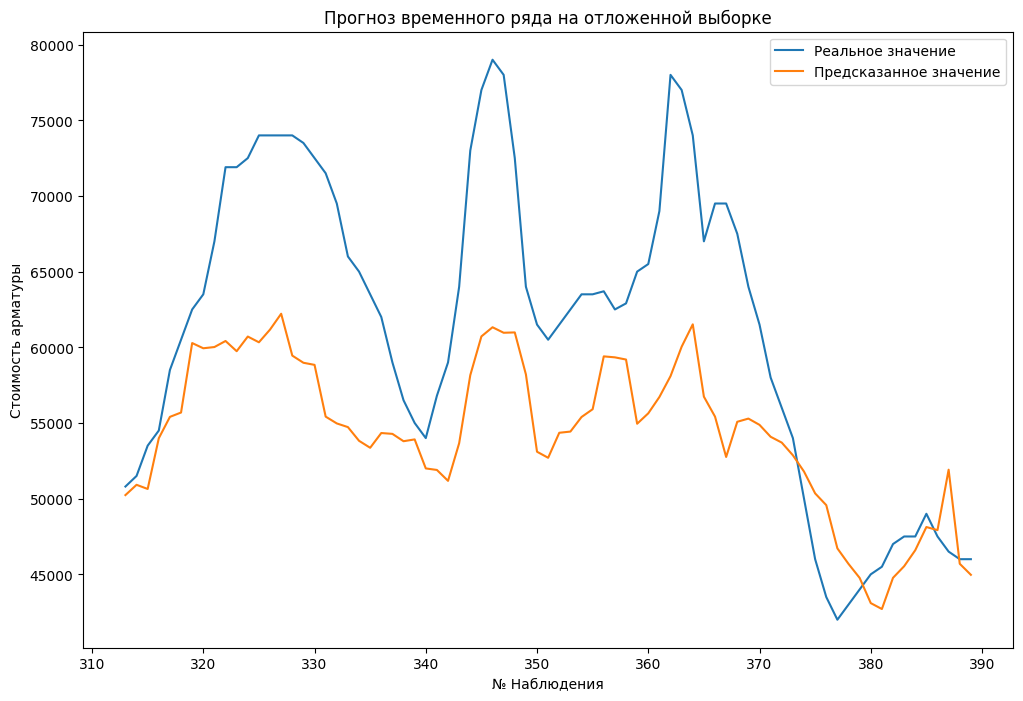

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(12, 8), dpi=100)


plt.plot(result['real'], label='Реальное значение');
plt.plot(result['pred'], label='Предсказанное значение');
plt.title('Прогноз временного ряда на отложенной выборке')
plt.xlabel('№ Наблюдения')
plt.ylabel('Стоимость арматуры')
plt.legend();

# Обучение на всей тренировочной выборке

In [ ]:
# Обучение модели №1
model0.fit(
    X[X_for_train].drop(columns=['istest']),
    y[X_for_train],
)

# Обучение модели №2
model1.fit(
    X[X_for_train].drop(columns=['istest']),
    y[X_for_train],
)

# Обучение модели №3
model2.fit(
    X[X_for_train].drop(columns=['istest']),
    y[X_for_train],
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, early_stopping_rounds=None,
             enable_categorical=True, eval_metric='mae', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=31,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=2, num_parallel_tree=None,
             predictor=None, random_state=32, ...)

### Сохраняем веса моделей

In [ ]:
pickle.dump(model0, open("xgb_reg1.pkl", "wb"))
pickle.dump(model1, open("xgb_reg2.pkl", "wb"))
pickle.dump(model2, open("xgb_reg3.pkl", "wb"))